In [1]:
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.messages import RemoveMessage

In [12]:
load_dotenv()

True

In [13]:
model = ChatOpenAI()

In [14]:
def chat(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": [response]}

def delete_old_messages(state: MessagesState):
    msgs = state["messages"]

    # if more than 10 messages, delete the earliest 6
    if len(msgs) > 10:
        to_remove = msgs[:6]
        return {"messages": [RemoveMessage(id=m.id) for m in to_remove]}

    return {}

In [15]:
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("cleanup", delete_old_messages)

In [16]:
builder.add_edge(START, "chat")
builder.add_edge("chat", "cleanup")   # run deletion after each response
builder.add_edge("cleanup", "__end__")

In [17]:
graph = builder.compile(checkpointer=InMemorySaver())

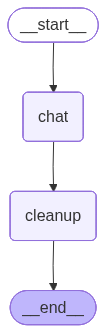

In [18]:
graph

In [19]:
config = {"configurable": {"thread_id": "t1"}}

In [20]:
# Run multiple turns
graph.invoke({"messages": [{"role": "user", "content": "Hi, I'm Nitish"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Tell me about LangGraph"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Now explain checkpointers"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Langchain"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Quantum Mechanics"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Gen AI"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is my name"}]}, config)

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='24983a35-def0-4c1e-820f-6fc8b65d517e'),
  AIMessage(content='I am not familiar with any specific technology or platform called Langchain. It is possible that it may refer to a project, company, or concept that is not widely known or recognized. If you can provide more context or details about Langchain, I may be able to offer more information or insights.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 271, 'total_tokens': 331, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CrXWRvjfysNV0oqwNAayRqDoDwTib', 'service_tier': 'default', 'finish_reason': 'stop'

In [21]:
snap = graph.get_state(config)
print("Stored messages after cleanup:", len(snap.values["messages"]))

Stored messages after cleanup: 8
